In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r "/content/drive/MyDrive/Projects/Brain MRI/Segmentation/requirements.txt"

In [ ]:
!unzip "/content/drive/MyDrive/Projects/Brain MRI/data/archive.zip" -d "/content/data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /content/data/lgg-mri-segmenta

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import warnings

import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


**Loading the dataset**

In [ ]:
Size = (256, 256)
mask_files = glob('/content/data/kaggle_3m/*/*_mask*')

In [ ]:
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import os

def process_file(mask_file):
    image_file = mask_file.replace('_mask', '')
    # Check if both files exist
    if os.path.exists(mask_file) and os.path.exists(image_file):
        return image_file, mask_file, label(mask_file)
    else:
        return None

# Lists to store data
images = []
masks = []
labels = []

# Define a function to process each file in parallel
def process_files(mask_files):
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_file, mask_files), total=len(mask_files), desc='Processing files'))

    for result in results:
        if result:
            image, mask, lbl = result
            images.append(image)
            masks.append(mask)
            labels.append(lbl)

# Call the function with your mask files
process_files(mask_files)


Processing files: 100%|██████████| 3929/3929 [00:04<00:00, 864.82it/s]


In [ ]:
# Create DataFrame
df = pd.DataFrame({
    "image": images,
    "mask": masks,
    "label": labels
})

In [ ]:
df.head()

,image,mask,label
0,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,0
1,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,0
2,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,0
3,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,0
4,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,/content/data/kaggle_3m/TCGA_FG_7643_20021104/...,1


In [ ]:
df.shape

(3929, 3)

In [ ]:
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3929 non-null   object
 1   mask    3929 non-null   object
 2   label   3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


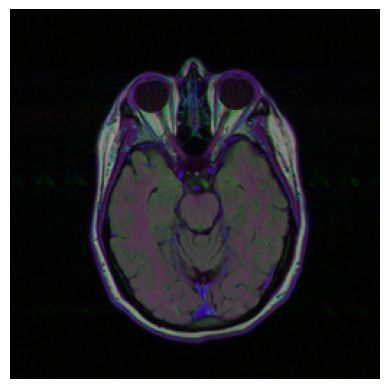

In [ ]:
import imageio
import matplotlib.pyplot as plt
from PIL import Image

# Open the image file
image_path = df['image'][0]
with Image.open(f"{image_path}") as img:
    plt.imshow(img)
    plt.axis('off') # to turn off axes
    plt.show()


In [ ]:
IMG_SIZE = img.size
IMG_SIZE

(256, 256)

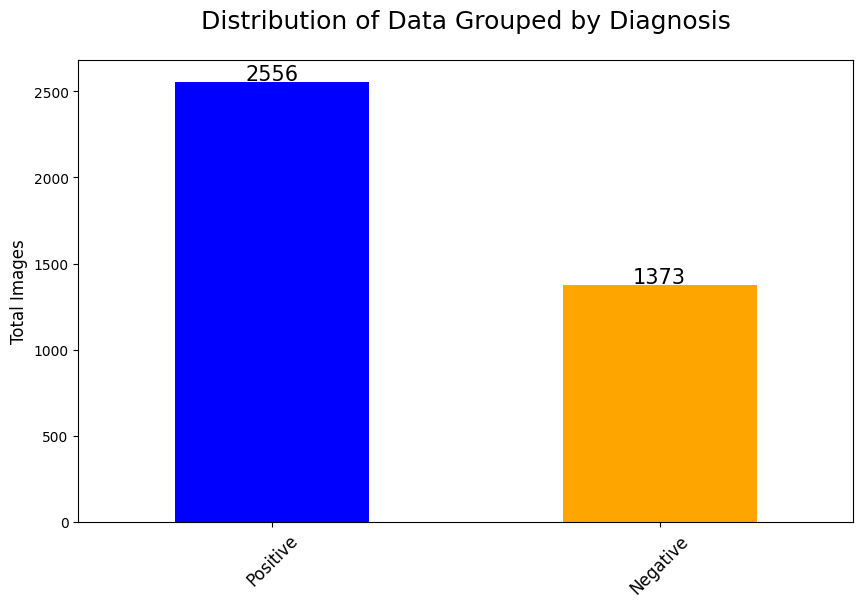

In [ ]:
counts = df['label'].value_counts()
colors = ["blue", "orange"]
labels = ["Positive", "Negative"]

ax = counts.plot.bar(stacked=True, figsize=(10, 6), color=colors)
ax.set_xticklabels(labels, rotation=45, fontsize=12)
ax.set_ylabel("Total Images", fontsize=12)
ax.set_title("Distribution of Data Grouped by Diagnosis", fontsize=18, y=1.05)

for i, count in enumerate(counts):
    ax.annotate(int(count), xy=(i, count+10), color="black", ha="center", fontsize=15)

plt.show()


## **Train Test Validation Split**

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3)
df_test, df_val = train_test_split(df_test, test_size=0.5)

print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2750, 3)
(590, 3)
(589, 3)


In [ ]:
BATCH_SIZE = 16

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        # print("Image shape:", img.shape)
        # print("Mask shape:", mask.shape)
        yield (img, mask[..., np.newaxis])

In [ ]:
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMG_SIZE)

val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMG_SIZE)

#Model

In [ ]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    input = dspp_input.shape


    x = layers.AveragePooling2D(pool_size=(input[-3], input[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)

    out_pool = layers.UpSampling2D(
        size=(input[-3] // x.shape[1], input[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)

    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):

  with tf.device('/GPU:0'):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )

    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)

    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="sigmoid")(x)


    return keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
model = DeeplabV3Plus(image_size=256, num_classes=1)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
loss = keras.losses.BinaryCrossentropy()
with tf.device('/GPU:0'):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=loss,
        metrics=["accuracy"],
    )

## **Training**

In [ ]:
NUM_EPOCHS = 50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early Stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4,
                               verbose=1,
                               restore_best_weights=True)

# Model Checkpoint to save the best model weights
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Projects/Brain MRI/Segmentation/checkpoints/DeepLab/best_DeepLab_weights.h5",
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)


In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    validation_data = val_gen,
                    validation_steps=len(df_val) // BATCH_SIZE,
                    verbose=1)

Found 2750 validated image filenames.
Found 2750 validated image filenames.
Epoch 1/50
171/171 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9793Found 590 validated image filenames.
Found 590 validated image filenames.

Epoch 1: val_loss improved from inf to 0.05457, saving model to /content/drive/MyDrive/Projects/Brain MRI/checkpoints/DeepLab/best_DeepLab_weights.h5
171/171 [==============================] - 166s 545ms/step - loss: 0.0616 - accuracy: 0.9793 - val_loss: 0.0546 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/50
171/171 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9951
Epoch 2: val_loss did not improve from 0.05457
171/171 [==============================] - 101s 540ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.0662 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/50
171/171 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9956
Epoch 3: val_loss did not improve from 0.05457
171/171 [=============

**Learning Curves**

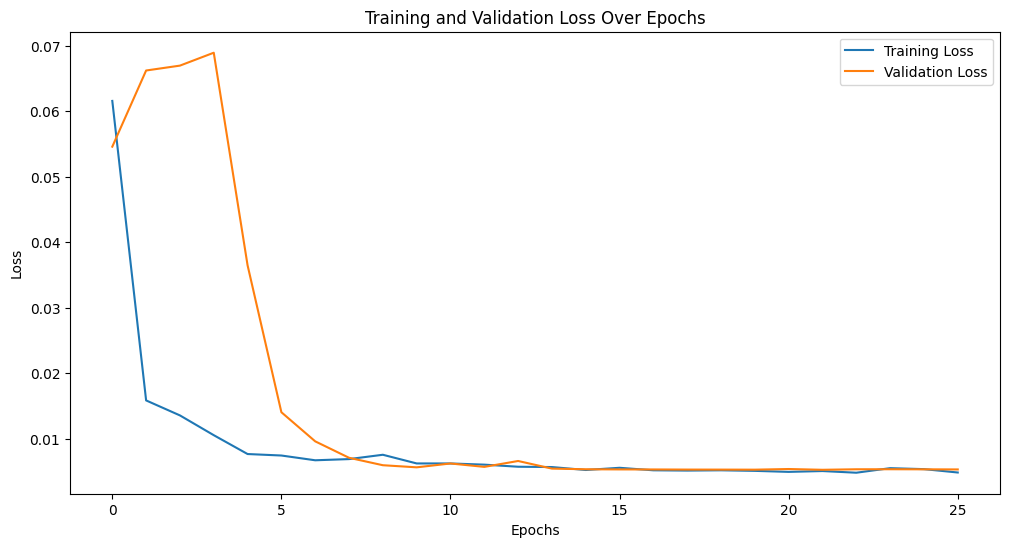

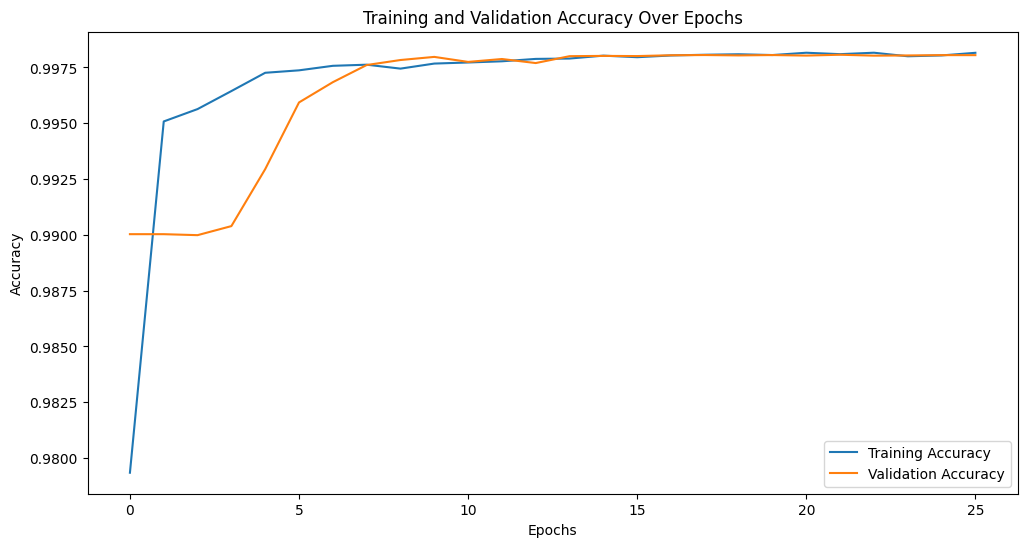

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# import joblib

# # Your trained model object (replace this with your actual model)
# trained_model = model

# # Path where you want to save the model file
# model_filename = '/content/drive/MyDrive/lgg-unet/model-checkpoint'

# # Save the model using joblib
# joblib.dump(trained_model, model_filename)

# print(f"Model saved to {model_filename}")

#Testing

In [ ]:
# Build the model architecture
model = DeeplabV3Plus(image_size=256, num_classes=1)

# Load the saved weights
model.load_weights(r"/content/drive/MyDrive/Projects/Brain MRI/Segmentation/checkpoints/DeepLab/best_DeepLab_weights.h5")


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [ ]:
BATCH_SIZE = 16
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=IMG_SIZE) # Assuming df_test is defined

## **Model Evaluation**

In [ ]:
df_test.shape

(589, 3)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm  # If you want to use tqdm for progress tracking

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

BATCH_SIZE = 16
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=IMG_SIZE) # Assuming df_test is defined

# Containers for metrics
iou_scores = []
f1_scores = []
pixel_accuracies = []

STEPS = (len(df_test) + BATCH_SIZE - 1) // BATCH_SIZE

for batch_index in tqdm(range(STEPS)):
    images, masks = next(test_gen)
    numpy_images = images if isinstance(images, np.ndarray) else np.array(images)
    numpy_masks = masks if isinstance(masks, np.ndarray) else np.array(masks)

    # Predict masks
    predicted_masks = model.predict(numpy_images)

    # Threshold the predicted masks
    threshold = 0.5
    predicted_masks_single_channel = (predicted_masks > threshold).astype(np.uint8)
    test_masks_single_channel = numpy_masks[..., 0] if numpy_masks.shape[-1] == 1 else numpy_masks.astype(np.uint8)

    for i in range(len(numpy_masks)):
        true_mask = test_masks_single_channel[i]
        pred_mask = predicted_masks_single_channel[i]

        if np.sum(true_mask) == 0 and np.sum(pred_mask) == 0:
            continue

        iou_scores.append(calculate_iou(true_mask, pred_mask))

        if np.sum(true_mask) == 0 or np.sum(pred_mask) == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(f1_score(true_mask.flatten(), pred_mask.flatten()))

        pixel_accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        pixel_accuracies.append(pixel_accuracy)

average_iou = np.nanmean(iou_scores)
average_f1 = np.nanmean(f1_scores)
average_pixel_accuracy = np.mean(pixel_accuracies)

print("\n\nPixel Accuracy:", average_pixel_accuracy)
print("Average IoU Score:", average_iou)
print("Average F1 Score:", average_f1)


  0%|          | 0/37 [00:00<?, ?it/s]

Found 589 validated image filenames.
Found 589 validated image filenames.
1/1 [==============================] - 10s 10s/step


  3%|▎         | 1/37 [00:11<06:37, 11.04s/it]

1/1 [==============================] - 10s 10s/step


  5%|▌         | 2/37 [00:21<06:18, 10.80s/it]

1/1 [==============================] - 9s 9s/step


  8%|▊         | 3/37 [00:30<05:39,  9.97s/it]

1/1 [==============================] - 9s 9s/step


 11%|█         | 4/37 [00:39<05:19,  9.69s/it]

1/1 [==============================] - 11s 11s/step


 14%|█▎        | 5/37 [00:51<05:27, 10.23s/it]

1/1 [==============================] - 8s 8s/step


 16%|█▌        | 6/37 [01:01<05:20, 10.35s/it]

1/1 [==============================] - 8s 8s/step


 19%|█▉        | 7/37 [01:10<04:53,  9.78s/it]

1/1 [==============================] - 10s 10s/step


 22%|██▏       | 8/37 [01:20<04:49, 10.00s/it]

1/1 [==============================] - 9s 9s/step


 24%|██▍       | 9/37 [01:31<04:43, 10.14s/it]

1/1 [==============================] - 8s 8s/step


 27%|██▋       | 10/37 [01:41<04:37, 10.28s/it]

1/1 [==============================] - 9s 9s/step


 30%|██▉       | 11/37 [01:51<04:21, 10.04s/it]

1/1 [==============================] - 10s 10s/step


 32%|███▏      | 12/37 [02:02<04:16, 10.26s/it]

1/1 [==============================] - 8s 8s/step


 35%|███▌      | 13/37 [02:12<04:07, 10.33s/it]

1/1 [==============================] - 8s 8s/step


 38%|███▊      | 14/37 [02:23<03:59, 10.41s/it]

1/1 [==============================] - 10s 10s/step


 41%|████      | 15/37 [02:33<03:48, 10.39s/it]

1/1 [==============================] - 11s 11s/step


 43%|████▎     | 16/37 [02:44<03:42, 10.61s/it]

1/1 [==============================] - 8s 8s/step


 46%|████▌     | 17/37 [02:53<03:20, 10.05s/it]

1/1 [==============================] - 10s 10s/step


 49%|████▊     | 18/37 [03:03<03:13, 10.18s/it]

1/1 [==============================] - 10s 10s/step


 51%|█████▏    | 19/37 [03:14<03:03, 10.18s/it]

1/1 [==============================] - 8s 8s/step


 54%|█████▍    | 20/37 [03:24<02:55, 10.31s/it]

1/1 [==============================] - 9s 9s/step


 57%|█████▋    | 21/37 [03:35<02:46, 10.38s/it]

1/1 [==============================] - 10s 10s/step


 59%|█████▉    | 22/37 [03:45<02:36, 10.43s/it]

1/1 [==============================] - 8s 8s/step


 62%|██████▏   | 23/37 [03:53<02:15,  9.71s/it]

1/1 [==============================] - 10s 10s/step


 65%|██████▍   | 24/37 [04:04<02:10, 10.05s/it]

1/1 [==============================] - 10s 10s/step


 68%|██████▊   | 25/37 [04:15<02:01, 10.16s/it]

1/1 [==============================] - 14s 14s/step


 70%|███████   | 26/37 [04:35<02:26, 13.35s/it]

1/1 [==============================] - 10s 10s/step


 73%|███████▎  | 27/37 [04:46<02:05, 12.51s/it]

1/1 [==============================] - 8s 8s/step


 76%|███████▌  | 28/37 [04:54<01:40, 11.21s/it]

1/1 [==============================] - 10s 10s/step


 78%|███████▊  | 29/37 [05:04<01:27, 10.90s/it]

1/1 [==============================] - 10s 10s/step


 81%|████████  | 30/37 [05:14<01:14, 10.71s/it]

1/1 [==============================] - 8s 8s/step


 84%|████████▍ | 31/37 [05:23<00:59,  9.95s/it]

1/1 [==============================] - 10s 10s/step


 86%|████████▋ | 32/37 [05:33<00:50, 10.13s/it]

1/1 [==============================] - 9s 9s/step


 89%|████████▉ | 33/37 [05:44<00:40, 10.25s/it]

1/1 [==============================] - 8s 8s/step


 92%|█████████▏| 34/37 [05:54<00:31, 10.38s/it]

1/1 [==============================] - 12s 12s/step


 95%|█████████▍| 35/37 [06:15<00:27, 13.52s/it]

1/1 [==============================] - 9s 9s/step


 97%|█████████▋| 36/37 [06:26<00:12, 12.59s/it]

1/1 [==============================] - 6s 6s/step


100%|██████████| 37/37 [06:36<00:00, 10.72s/it]



Pixel Accuracy: 0.9947150202080755
Average IoU Score: 0.7116263942287882
Average F1 Score: 0.7927737136141315
